# LOF

LOF is a density-based outlier detection algorithm that compares the local density of a point with the densities of its neighbors. Unlike distance-based methods that only consider how far a point is from others, LOF considers how isolated the point is relative to its neighbors' isolation.


``` Normal points: Have similar density to their neighbors ```

Outliers: Have significantly lower density than their neighbors

Mathematical Foundation
1. k-Distance and k-Distance Neighborhood
text
Let k-distance(p) = distance to k-th nearest neighbor
N_k(p) = set of points within k-distance(p)
2. Reachability Distance
text
reach-dist_k(p, o) = max(k-distance(o), distance(p, o))
This ensures stability - points deep inside dense clusters aren't penalized.

3. Local Reachability Density (LRD)
text
LRD_k(p) = 1 / ( avg(reach-dist_k(p, o)) for o in N_k(p) )
High LRD = dense region

Low LRD = sparse region

4. Local Outlier Factor
text
LOF_k(p) = avg( LRD_k(o) / LRD_k(p) ) for o in N_k(p)
Interpretation:

LOF ≈ 1: Point has similar density to neighbors (normal)

LOF < 1: Point has higher density than neighbors (inlier)

LOF > 1: Point has lower density than neighbors (outlier)

### Step-by-Step Example
``` bash
Let's walk through a simple example:

Dataset:


A: [1, 1]
B: [1, 2]
C: [2, 1]
D: [2, 2]
E: [8, 8]  ← Potential outlier
Using k=2:

Step 1: Calculate k-distance (k=2)

k-distance(A) = distance to 2nd nearest neighbor
Neighbors: B(1.0), C(1.0) → k-distance = 1.0

Similarly:
k-distance(B) = 1.0
k-distance(C) = 1.0  
k-distance(D) = 1.0
k-distance(E) = distance to 2nd nearest neighbor
Neighbors: D(8.49), C(9.22) → k-distance = 9.22
Step 2: Calculate Reachability Distances
For point A to its neighbors:


reach-dist(A, B) = max(k-distance(B), dist(A,B)) = max(1.0, 1.0) = 1.0
reach-dist(A, C) = max(k-distance(C), dist(A,C)) = max(1.0, 1.0) = 1.0
For point E to its neighbors:


reach-dist(E, D) = max(k-distance(D), dist(E,D)) = max(1.0, 8.49) = 8.49
reach-dist(E, C) = max(k-distance(C), dist(E,C)) = max(1.0, 9.22) = 9.22
Step 3: Calculate Local Reachability Density (LRD)
For point A:


avg_reach_dist = (1.0 + 1.0) / 2 = 1.0
LRD(A) = 1 / 1.0 = 1.0
For point E:


avg_reach_dist = (8.49 + 9.22) / 2 = 8.855
LRD(E) = 1 / 8.855 = 0.113
Step 4: Calculate LOF
For point A:


LOF(A) = avg(LRD(neighbors) / LRD(A))
        = avg(LRD(B)/LRD(A) + LRD(C)/LRD(A)) / 2
        = avg(1.0/1.0 + 1.0/1.0) / 2
        = 1.0
For point E:


LOF(E) = avg(LRD(D)/LRD(E) + LRD(C)/LRD(E)) / 2
        = avg(1.0/0.113 + 1.0/0.113) / 2
        = avg(8.85 + 8.85) / 2
        = 8.85
Result: LOF(E) = 8.85 >> 1 → E is an outlier!

```



=== Example 1: Simple 2D Dataset ===
Total points: 234
Outliers detected: 12
LOF score range: [0.953, 15.559]

=== Point Explanations ===
Point 230: [15. 15.]
LOF Score: 15.559
Interpretation: Strong outlier
k-th distance: 10.043


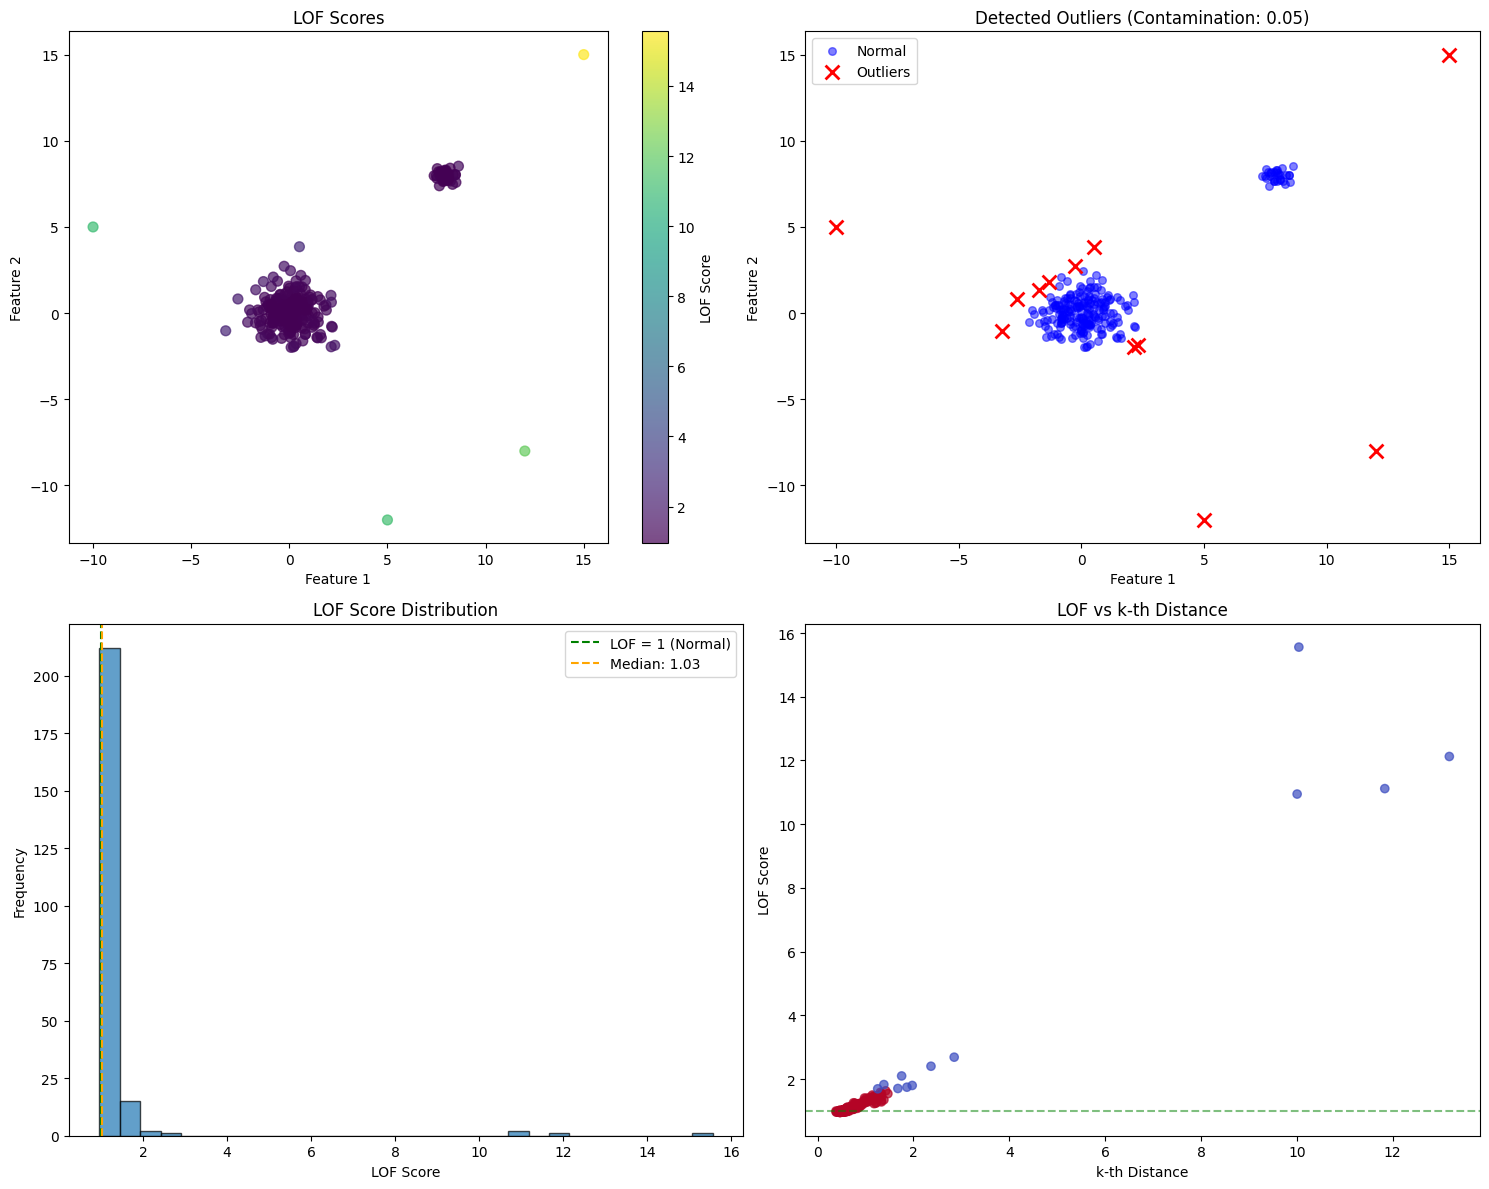


=== Example 2: Sensitivity to k ===
Sensitivity to k parameter:
    k  n_outliers  mean_lof  outlier_ratio
0   5          15  1.350576       0.064103
1  10          14  1.346855       0.059829
2  15          16  1.328820       0.068376
3  20          16  1.313385       0.068376
4  25          16  1.300594       0.068376
5  30          15  1.257171       0.064103
6  35          46  1.364252       0.196581
7  40          47  1.451681       0.200855
8  45          46  1.518364       0.196581
9  50          43  1.571062       0.183761

=== Example 3: Network Intrusion Detection ===

Network Intrusion Detection Results:
              precision    recall  f1-score   support

      Normal       0.05      0.00      0.00      1000
      Attack       0.00      0.00      0.00        20

    accuracy                           0.00      1020
   macro avg       0.02      0.00      0.00      1020
weighted avg       0.05      0.00      0.00      1020

Confusion Matrix:
[[  1 999]
 [ 20   0]]
Attack D

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd

class LOFExplainer:
    """
    Comprehensive LOF implementation with explanations
    """
    
    def __init__(self, k=20, contamination=0.1):
        self.k = k
        self.contamination = contamination
        self.lof = LocalOutlierFactor(
            n_neighbors=k,
            contamination=contamination,
            novelty=False
        )
    
    def fit_predict(self, X):
        """
        Fit LOF and return predictions
        """
        self.X = np.array(X)
        self.outlier_labels = self.lof.fit_predict(self.X)
        self.lof_scores = -self.lof.negative_outlier_factor_
        
        # Get detailed neighbor information
        self._calculate_detailed_metrics()
        
        return self.outlier_labels, self.lof_scores
    
    def _calculate_detailed_metrics(self):
        """
        Calculate detailed LOF metrics for analysis
        """
        from sklearn.neighbors import NearestNeighbors
        
        # Get k+1 neighbors (including self)
        nbrs = NearestNeighbors(n_neighbors=self.k+1).fit(self.X)
        distances, indices = nbrs.kneighbors(self.X)
        
        self.neighbor_distances = distances
        self.neighbor_indices = indices
        
        # Calculate custom metrics for explanation
        self.metrics = {
            'avg_neighbor_distance': np.mean(distances[:, 1:], axis=1),
            'kth_distance': distances[:, self.k],
            'isolation_score': distances[:, self.k] / np.mean(distances[:, self.k])
        }
    
    def explain_point(self, point_index):
        """
        Provide detailed explanation for a specific point
        """
        if not hasattr(self, 'metrics'):
            raise ValueError("Must fit the model first")
        
        lof_score = self.lof_scores[point_index]
        is_outlier = self.outlier_labels[point_index] == -1
        
        explanation = {
            'point': self.X[point_index],
            'lof_score': lof_score,
            'is_outlier': is_outlier,
            'kth_distance': self.metrics['kth_distance'][point_index],
            'avg_neighbor_distance': self.metrics['avg_neighbor_distance'][point_index],
            'neighbors': self.neighbor_indices[point_index, 1:self.k+1],
            'neighbor_distances': self.neighbor_distances[point_index, 1:self.k+1]
        }
        
        # Interpretation
        if lof_score < 0.9:
            explanation['interpretation'] = 'Inlier (denser than neighbors)'
        elif lof_score <= 1.1:
            explanation['interpretation'] = 'Normal (similar density to neighbors)'
        elif lof_score <= 2.0:
            explanation['interpretation'] = 'Mild outlier'
        else:
            explanation['interpretation'] = 'Strong outlier'
        
        return explanation
    
    def visualize(self):
        """
        Visualize LOF results
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Data points colored by LOF score
        scatter1 = axes[0, 0].scatter(self.X[:, 0], self.X[:, 1], 
                                     c=self.lof_scores, cmap='viridis', 
                                     alpha=0.7, s=50)
        plt.colorbar(scatter1, ax=axes[0, 0], label='LOF Score')
        axes[0, 0].set_title('LOF Scores')
        axes[0, 0].set_xlabel('Feature 1')
        axes[0, 0].set_ylabel('Feature 2')
        
        # Plot 2: Outliers highlighted
        normal_mask = self.outlier_labels != -1
        outlier_mask = self.outlier_labels == -1
        
        axes[0, 1].scatter(self.X[normal_mask, 0], self.X[normal_mask, 1],
                          c='blue', alpha=0.5, s=30, label='Normal')
        axes[0, 1].scatter(self.X[outlier_mask, 0], self.X[outlier_mask, 1],
                          c='red', s=100, marker='x', linewidth=2, label='Outliers')
        axes[0, 1].set_title(f'Detected Outliers (Contamination: {self.contamination})')
        axes[0, 1].set_xlabel('Feature 1')
        axes[0, 1].set_ylabel('Feature 2')
        axes[0, 1].legend()
        
        # Plot 3: LOF score distribution
        axes[1, 0].hist(self.lof_scores, bins=30, alpha=0.7, edgecolor='black')
        axes[1, 0].axvline(1.0, color='green', linestyle='--', label='LOF = 1 (Normal)')
        axes[1, 0].axvline(np.median(self.lof_scores), color='orange', 
                          linestyle='--', label=f'Median: {np.median(self.lof_scores):.2f}')
        axes[1, 0].set_title('LOF Score Distribution')
        axes[1, 0].set_xlabel('LOF Score')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        
        # Plot 4: Relationship between k-distance and LOF
        axes[1, 1].scatter(self.metrics['kth_distance'], self.lof_scores,
                          c=self.outlier_labels, cmap='coolwarm', alpha=0.7)
        axes[1, 1].set_xlabel('k-th Distance')
        axes[1, 1].set_ylabel('LOF Score')
        axes[1, 1].set_title('LOF vs k-th Distance')
        axes[1, 1].axhline(1.0, color='green', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()

# Example 1: Simple dataset
print("=== Example 1: Simple 2D Dataset ===")
np.random.seed(42)

# Create main cluster
main_cluster = np.random.normal(0, 1, (200, 2))

# Create sparse cluster
sparse_cluster = np.random.normal(8, 0.3, (30, 2))

# Add isolated outliers
outliers = np.array([
    [15, 15],    # Far from everything
    [-10, 5],    # Far in negative x
    [5, -12],    # Far in negative y
    [12, -8]     # Far in diagonal
])

X = np.vstack([main_cluster, sparse_cluster, outliers])

# Apply LOF
lof_explainer = LOFExplainer(k=20, contamination=0.05)
labels, scores = lof_explainer.fit_predict(X)

print(f"Total points: {len(X)}")
print(f"Outliers detected: {np.sum(labels == -1)}")
print(f"LOF score range: [{np.min(scores):.3f}, {np.max(scores):.3f}]")

# Explain specific points
print("\n=== Point Explanations ===")
point_to_explain = len(main_cluster) + len(sparse_cluster)  # First outlier
explanation = lof_explainer.explain_point(point_to_explain)
print(f"Point {point_to_explain}: {explanation['point']}")
print(f"LOF Score: {explanation['lof_score']:.3f}")
print(f"Interpretation: {explanation['interpretation']}")
print(f"k-th distance: {explanation['kth_distance']:.3f}")

# Visualize
lof_explainer.visualize()

# Example 2: Comparing different k values
print("\n=== Example 2: Sensitivity to k ===")

def analyze_k_sensitivity(X, k_values=range(5, 51, 5)):
    """
    Analyze how LOF changes with different k values
    """
    results = []
    
    for k in k_values:
        lof_model = LocalOutlierFactor(n_neighbors=k, contamination='auto')
        labels = lof_model.fit_predict(X)
        scores = -lof_model.negative_outlier_factor_
        
        results.append({
            'k': k,
            'n_outliers': np.sum(labels == -1),
            'mean_lof': np.mean(scores),
            'median_lof': np.median(scores),
            'max_lof': np.max(scores),
            'outlier_ratio': np.sum(labels == -1) / len(X)
        })
    
    return pd.DataFrame(results)

# Perform sensitivity analysis
k_sensitivity_df = analyze_k_sensitivity(X)
print("Sensitivity to k parameter:")
print(k_sensitivity_df[['k', 'n_outliers', 'mean_lof', 'outlier_ratio']])

# Example 3: Real-world scenario - Network Intrusion Detection
print("\n=== Example 3: Network Intrusion Detection ===")

def simulate_network_traffic():
    """
    Simulate network traffic features for intrusion detection
    """
    np.random.seed(123)
    n_normal = 1000
    n_attack = 20
    
    # Normal traffic patterns
    normal_traffic = np.column_stack([
        np.random.exponential(100, n_normal),      # Packet size
        np.random.exponential(2, n_normal),        # Duration
        np.random.poisson(50, n_normal),           # Frequency
        np.random.beta(2, 5, n_normal),           # Protocol mix (0-1)
    ])
    
    # Attack patterns (different distributions)
    attack_traffic = np.column_stack([
        np.random.exponential(500, n_attack),      # Large packets
        np.random.exponential(0.1, n_attack),      # Short duration bursts
        np.random.poisson(200, n_attack),          # High frequency
        np.random.beta(8, 1, n_attack),           # Different protocol mix
    ])
    
    # Combine and add labels
    X_network = np.vstack([normal_traffic, attack_traffic])
    y_true = np.array([0]*n_normal + [1]*n_attack)
    
    return X_network, y_true

# Generate network data
X_network, y_true = simulate_network_traffic()

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_network_scaled = scaler.fit_transform(X_network)

# Apply LOF for anomaly detection
lof_network = LocalOutlierFactor(n_neighbors=50, contamination=0.02)
y_pred = lof_network.fit_predict(X_network_scaled)
scores_network = -lof_network.negative_outlier_factor_

# Convert predictions (1 for normal, -1 for outlier)
y_pred_binary = (y_pred == 1).astype(int)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix
print("\nNetwork Intrusion Detection Results:")
print(classification_report(y_true, y_pred_binary, 
                           target_names=['Normal', 'Attack']))

# Analyze detection quality
cm = confusion_matrix(y_true, y_pred_binary)
print(f"Confusion Matrix:\n{cm}")
print(f"Attack Detection Rate: {cm[1,1]}/{cm[1,:].sum()} = {cm[1,1]/cm[1,:].sum():.2%}")

# Advanced: LOF Variants and Extensions
class EnhancedLOF:
    """
    Enhanced LOF with additional features
    """
    
    def __init__(self, k_range=(10, 50)):
        self.k_range = k_range
    
    def adaptive_lof(self, X):
        """
        Adaptive LOF that tries multiple k values
        """
        from sklearn.neighbors import LocalOutlierFactor
        
        results = {}
        k_min, k_max = self.k_range
        
        for k in range(k_min, k_max + 1, 5):
            lof = LocalOutlierFactor(n_neighbors=k, contamination='auto')
            scores = -lof.fit_predict(X)
            
            # Calculate stability metric
            if 'previous_scores' in results:
                stability = np.corrcoef(results['previous_scores'], scores)[0, 1]
            else:
                stability = 1.0
            
            results[k] = {
                'scores': scores,
                'n_outliers': np.sum(scores > 1.5),  # Threshold for outlier
                'stability': stability
            }
            results['previous_scores'] = scores
        
        # Choose best k based on stability and outlier count
        best_k = max(results.keys(), 
                    key=lambda k: results[k]['stability'] - 0.1 * results[k]['n_outliers'])
        
        return results[best_k]['scores'], best_k
    
    def contextual_lof(self, X, context_features):
        """
        LOF that considers contextual information
        """
        # Weight features based on context importance
        from sklearn.preprocessing import normalize
        
        # Calculate feature importance (simplified)
        feature_importance = np.std(X, axis=0)
        weighted_X = X * feature_importance
        
        # Apply LOF on weighted features
        lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
        scores = -lof.fit_predict(weighted_X)
        
        return scores

# Example of using enhanced LOF
print("\n=== Enhanced LOF Example ===")
enhanced_lof = EnhancedLOF(k_range=(10, 40))
adaptive_scores, best_k = enhanced_lof.adaptive_lof(X)
print(f"Adaptive LOF selected k={best_k}")
print(f"Outliers detected: {np.sum(adaptive_scores > 1.5)}")



tips = """
1. CHOOSING k:
   - Small k: More local, detects small anomalies
   - Large k: More global, detects larger anomalies
   - Rule of thumb: Start with k = min(20, 0.1 * n_samples)

2. FEATURE SCALING:
   - Always scale features before LOF
   - Use StandardScaler or MinMaxScaler

3. CONTAMINATION PARAMETER:
   - 'auto': Let algorithm determine
   - Float: Expected proportion of outliers
   - Domain knowledge should guide this

4. INTERPRETING LOF SCORES:
   - LOF < 1: Inlier (denser than neighbors)
   - LOF ≈ 1: Normal point
   - LOF > 1: Potential outlier
   - LOF > 2: Strong outlier candidate

5. COMPUTATIONAL OPTIMIZATION:
   - Use ball_tree or kd_tree for large datasets
   - Consider sampling for very large datasets
   - Use approximate nearest neighbors if precision isn't critical

6. VALIDATION:
   - Use domain knowledge to validate outliers
   - Consider multiple k values
   - Compare with other outlier detection methods
"""

print(tips)

# Comparative Analysis with Other Methods
def compare_outlier_methods(X):
    """
    Compare LOF with other outlier detection methods
    """
    from sklearn.ensemble import IsolationForest
    from sklearn.neighbors import NearestNeighbors
    from sklearn.svm import OneClassSVM
    
    results = {}
    
    # 1. LOF
    lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
    results['LOF'] = -lof.fit_predict(X)
    
    # 2. Isolation Forest
    iso_forest = IsolationForest(contamination='auto', random_state=42)
    results['IsolationForest'] = -iso_forest.fit_predict(X)
    
    # 3. One-Class SVM
    oc_svm = OneClassSVM(gamma='auto', nu=0.1)
    results['OneClassSVM'] = -oc_svm.fit_predict(X)
    
    # 4. Simple distance-based
    nbrs = NearestNeighbors(n_neighbors=20).fit(X)
    distances, _ = nbrs.kneighbors(X)
    results['DistanceBased'] = distances[:, -1]  # Distance to k-th neighbor
    
    return results

# Compare methods
print("\n=== Method Comparison ===")
method_scores = compare_outlier_methods(X)

# Analyze correlation between methods
import pandas as pd
scores_df = pd.DataFrame(method_scores)
correlation_matrix = scores_df.corr()

print("Correlation between outlier detection methods:")
print(correlation_matrix)

LOF is a density-based outlier detection algorithm that compares the local density of a point with the densities of its neighbors. Unlike simple distance-based methods, LOF can identify outliers that might be close to a cluster but exist in lower-density regions.

The key insight is that outliers have significantly lower local density compared to their neighbors. The algorithm calculates a Local Outlier Factor score where values around 1 indicate normal points, values below 1 indicate inliers (points in dense regions), and values above 1 indicate outliers.

LOF is particularly powerful for detecting contextual outliers - points that might not be globally extreme but are anomalous within their local context. It's widely used in fraud detection, network security, and quality control.

### When to Use LOF
- Excellent for:

Detecting outliers in clustered data

Finding local anomalies near dense regions

Situations where relative density matters

Data with varying cluster densities

- Not ideal for:

Very high-dimensional data (curse of dimensionality)

Streaming data (computationally expensive)

When global outliers are the primary concern